In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from pacmagic_deeplearning.modeling.classifiers.bayesian.train_utils import make_performance_uncertainty_plot

In [2]:
class MLP(nn.Module):
    """Simple MLP with dropout option.

    Parameters
    ----------
    in_dim: int
        Number of features in
    n_classes: int
        Number of classes
    p: float
        Dropout probability.
    """

    def __init__(self,
                 in_dim: int,
                 n_classes: int,
                 hidden_dims: tuple = (32, 32),
                 p: float = 0.1,
                 class_weights: list = None):
        super(MLP, self).__init__()
        self.dropout_p: float = p

        self.architecture: list = [in_dim] + [dim for dim in hidden_dims] + [n_classes]

        self.layers: list = []

        # Add linear combinations to the forward function. So iterating up to the n-1th layer and
        # adding combinations up to the nth layer.
        for i in range(len(self.architecture) - 1):
            self.layers.append(nn.Linear(self.architecture[i], self.architecture[i + 1]))

            # Don't add these in the final linear combination.
            if i < len(self.architecture) - 2:
                self.layers.append(nn.ReLU())
                self.layers.append(nn.Dropout(p=self.dropout_p))

        self.f: nn.Sequential = nn.Sequential(*self.layers)
        self.n_classes: int = n_classes
        self.in_dim: int = in_dim
        self.n_samples = 512

        weight_tensor = None  # Placeholder
        if self.n_classes == 1:
            if class_weights is not None:
                weight_tensor = torch.Tensor([class_weights[1]])
            self.nll = nn.BCEWithLogitsLoss(pos_weight=weight_tensor, reduction='sum')

        else:
            if class_weights is not None:
                weight_tensor = torch.Tensor(class_weights)
            self.nll = nn.CrossEntropyLoss(weight=weight_tensor, reduction='sum')

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        """Pytorch forward funcion.

        Parameters
        ----------
        input_tensor: torch.Tensor
            input tensor.

        Returns
        -------
        output_tensor: torch.Tensor
            output tensor.
        """
        if len(input_tensor.shape) > 2:
            x: torch.Tensor = input_tensor.view(-1, self.in_dim)
        else:
            x = input_tensor
        output_tensor: torch.Tensor = self.f(x)
        return output_tensor


In [3]:
X_train = pd.read_csv('../../data/MIMIC/X_train_processed.csv')
y_train = pd.read_csv('../../data/MIMIC/y_train.csv')

X_test = pd.read_csv('../../data/MIMIC/X_test_processed.csv')
y_test = pd.read_csv('../../data/MIMIC/y_test.csv')

In [9]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.z = nn.Linear(44, 64)
        self.quantile_preds = nn.Linear(64, 1)
        
    def forward(self, x):
        z = self.z(x)
        return self.quantile_preds(z)

In [10]:
model = NN()

In [11]:
data = torch.from_numpy(X_train.values).float()
target = torch.from_numpy(y_train.values).float()

In [12]:
data_val = torch.from_numpy(X_test.values).float()
target_val = torch.from_numpy(y_test.values).float()

In [13]:
from torch.optim import SGD

In [14]:
optimizer = SGD(model.parameters(), lr=5e-1, momentum=0.9, nesterov=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [15]:
best_val_loss = np.inf
patience = 0

for epoch_idx in range(10000):
    outputs = model(data)
    loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs, 
                                                                target)        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch_idx % 10 == 0:
        outputs_val = model(data_val)
        loss_val = torch.nn.functional.binary_cross_entropy_with_logits(
        outputs_val, 
        target_val) 
            
        print(loss_val.item())
            
        if loss_val.item() < best_val_loss:
            best_val_loss = loss_val.item()
        else:
            patience += 1
            
            if patience == 8:
                break

0.5347248315811157
0.33144915103912354
0.28487440943717957
0.26319459080696106
0.24550354480743408
0.23249241709709167
0.2207333743572235
0.20878715813159943
0.19954711198806763
0.19315826892852783
0.18896377086639404
0.18642336130142212
0.18472400307655334
0.18351292610168457
0.18263141810894012
0.18199537694454193
0.18150782585144043
0.1811079978942871
0.1807650327682495
0.180459126830101
0.18017606437206268
0.17990833520889282
0.1796526461839676
0.1794053465127945
0.1791638731956482
0.17892633378505707
0.1786910891532898
0.17845723032951355
0.1782243549823761
0.17799212038516998
0.17776018381118774
0.1775282621383667
0.17729619145393372
0.17706389725208282
0.17683149874210358
0.17659902572631836
0.17636677622795105
0.17613500356674194
0.17590442299842834
0.17567527294158936
0.17544831335544586
0.1752241998910904
0.1750038117170334
0.17478778958320618
0.1745770126581192
0.1743723303079605
0.17417456209659576
0.17398425936698914
0.17428073287010193
0.17367321252822876
0.17392879724502

In [30]:
probs = torch.sigmoid(outputs_val).detach().numpy()

In [27]:
preds = torch.sigmoid(outputs_val).detach().numpy() > y_train.values.mean()

In [32]:
np.median(probs)

0.01993769

In [33]:
len(probs[probs > 0.01993769])

2238

In [49]:
np.percentile(probs, 100 * (1-y_train.values.mean()))

0.2804012064378504

In [50]:
len(probs)

4477

In [51]:
preds = probs > np.percentile(probs, 100 * (1-y_train.values.mean()))

In [53]:
(preds == y_test).mean()

EXPIRED_THIS_ICUSTAY    0.934108
dtype: float64

In [18]:

from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.figure import Figure
from matplotlib.lines import Line2D
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve

from pacmagic.general_utils.constants import *
from pacmagic.modeling.survival_models.kaplan_meier import get_and_fit_kaplan_meier
from pacmagic.visualizing.visualization_settings import *
from pacmagic.visualizing.visualization_utils import set_default_style

# Calibration curve
COLOR_TRAIN_ROC = 'b'
STD_AUC_FIELD = 'std_auc'
MEAN_FPR_FIELD = 'mean_fpr'
MEAN_TPR_FIELD = 'mean_tpr'
COLOR_TEST_ROC = 'orange'
LINE_WIDTH = 2
COLOR_PREDICTIONS = 'green'
PREDICTED_DIST_BINS = 40

LABEL_PERFECTLY_CALIBRATED = 'Perfectly calibrated'
LABEL_PREDICTIONS = 'Predictions'
LABEL_CI = 'Confidence Interval'

Y_PROB_COL = 'y_prob'
Y_TRUE_COL = 'y_true'
Y_CI_UPPER_COL = 'y_ci_upper'
Y_CI_LOWER_COL = 'y_ci_lower'
GROUP_COL = 'group'

set_default_style()

LEGEND_LOCATION_BEST = 'best'
HAZARD_PLOT_X_LABEL = 'time $t$'
HAZARD_PLOT_Y_LABEL = 'Est. probability of survival at t'
STEP_PLACEMENT = 'post'

ACTUAL_END_SCATTER_SIZE = 80
ORDER_IN_FRONT = 1

MARKER_CENSORING = 'o'
MARKER_EVENT = 'D'
SURVIVAL_MARKERSIZE = 10
SURVIVAL_MARKERFACECOLOR = 'grey'
SURVIVAL_LEGEND_COLOR = 'w'

def plot_calibration_curve(y_true, y_prob,
                           y_min: float = 0,
                           y_max: float = 1,
                           n_bins: int = 5,
                           n_std: int = 4,
                           y_std=None,
                           n: int = None,
                           z: float = 1.645,
                           ) -> Figure:
    """Plot the calibration curve. This curve shows if predicted probabilities and observed
    frequencies are inline. For example, if well calibrated 100 observations with y_pred = 0.1
    should contain 10 observation with y_true = 1

    Parameters
    ----------
    y_true : array-like
        Target value of y.
    y_prob : array-like
        Predicted probability values of y.
    y_min : float, optional
        Minimum value of the value axis.
    y_max : float, optional
        Maximum value of the value axis, y_pred > y_max will be maximized to y_max.
    n_bins : int, optional
        Number of bins of the histograms.
    n_std : int, optional
        Number of standard deviations to include.
    y_std: array-like, optional
        If you have a Bayesian standard deviation around your predictions
    n: int, optional
        Number of samples taken (in Bayesian Case)
    z: float, optional
        Z value for confidence interval.

    Returns
    -------
    type: matplotlib.figure.Figure
        A plot

    """

    # Make dataframe with y_true and y_pred
    df_plot = pd.DataFrame(y_prob)
    df_plot.columns = [Y_PROB_COL]
    df_plot[Y_TRUE_COL] = y_true
    if y_std is not None:
        df_plot[Y_CI_UPPER_COL] = y_prob + z * (y_std / n ** 0.5)
        df_plot[Y_CI_LOWER_COL] = y_prob - z * (y_std / n ** 0.5)

    # Initialize plot
#     # Make histogram of predicted probabilities
#     x = df_plot[Y_PROB_COL].values
#     x = np.maximum(np.minimum(x, y_max), y_min)
#     ax1.hist(x, bins=n_bins, color=SKYBLUE_COLOR)

    # Overlay the calibration curve
    mean = df_plot[Y_PROB_COL].mean()
    std = df_plot[Y_PROB_COL].std()

    # Make bins for the calibration
    df_plot[GROUP_COL] = df_plot[Y_PROB_COL].apply(lambda a: np.round((a - mean) / std))
    df_plot[GROUP_COL] = np.minimum(np.maximum(df_plot[GROUP_COL], -n_std), n_std)
    df_plot[GROUP_COL] = df_plot[GROUP_COL].apply(lambda a: mean + std * a)
    df_plot[GROUP_COL] = np.maximum(np.minimum(df_plot[GROUP_COL], y_max), y_min)

    
    df_agg = df_plot.groupby(GROUP_COL)[Y_TRUE_COL, Y_PROB_COL].mean().reset_index()

    y_u = None
    y_l = None

    x = df_agg[Y_PROB_COL]
    y = df_agg[Y_TRUE_COL]

    # Plot the calibration curve
    return x, y
#     plt.plot(x, x, DOT_LINE_STYLE, color=COLOR_NEUTRAL, label=LABEL_PERFECTLY_CALIBRATED)
    
    return fig


In [19]:
outputs = [torch.sigmoid(output) for output in outputs]

In [20]:
plots = []

for output in outputs:
    plots.append(plot_calibration_curve(y_train, output.detach().numpy()))

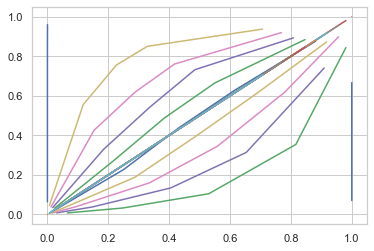

In [21]:
for plot in plots:
    plt.plot(plot[0], plot[1])
    plt.plot(plot[0], plot[0])
    
plt.show()

In [22]:
from pacmagic.visualizing.model_plots import plot_calibration_curve

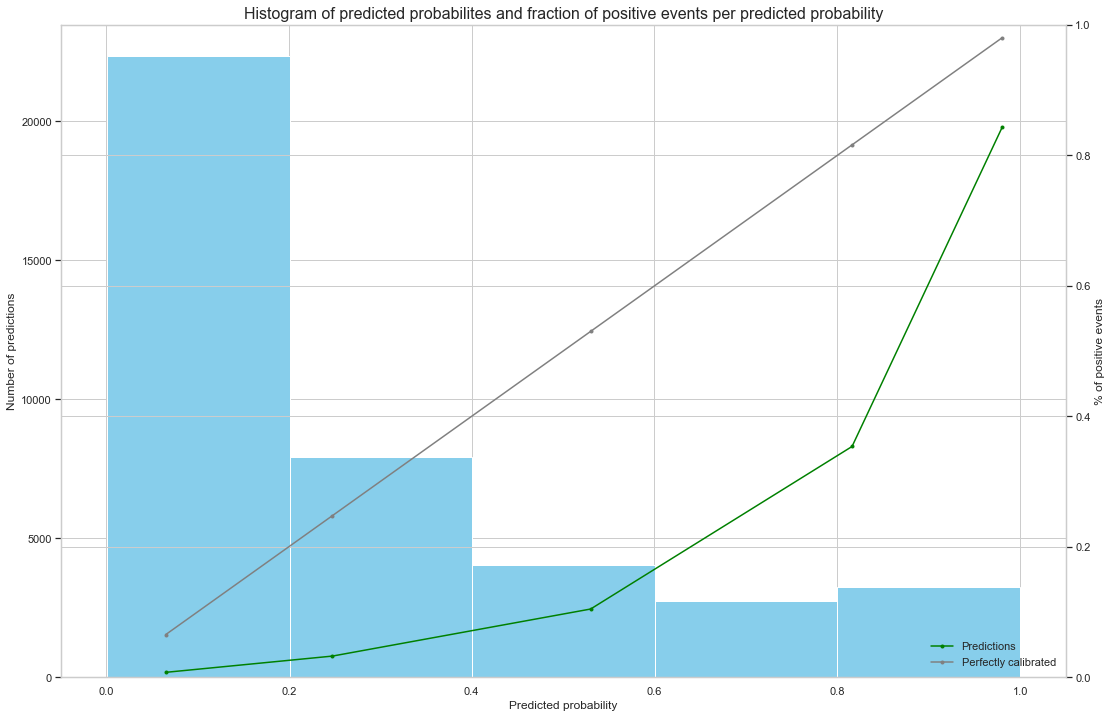

In [23]:
plot_calibration_curve(y_train, outputs[1].detach().numpy())

In [24]:
outputs_val = torch.stack([torch.sigmoid(output_val.squeeze()) for output_val in outputs_val], dim=1).detach().numpy().round(3)

In [25]:
preds = (outputs_val > target.mean().item())

In [31]:
(preds == np.repeat(y_test.values, 11, axis=1)).mean(axis=0)

array([0.087782  , 0.41746705, 0.61045343, 0.72057181, 0.79271834,
       0.84699576, 0.89032834, 0.91489837, 0.93366093, 0.94170203,
       0.912218  ])

In [92]:
preds_50 = preds[:, 5]

In [93]:
(preds_50.squeeze() == y_test.values.squeeze()).mean()

0.8469957560866652

In [32]:
quantiles

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [60]:
(preds == np.repeat(y_test.values, 11, axis=1)).any(axis=1).mean()

1.0

In [68]:
(preds[:, 1: 10] == np.repeat(y_test.values, 9, axis=1)).any(axis=1).mean()

0.9839178020996203

In [69]:
(preds[:, 2 : 9] == np.repeat(y_test.values, 7, axis=1)).any(axis=1).mean()

0.9620281438463256

In [70]:
(preds[:, 3:  8] == np.repeat(y_test.values, 5, axis=1)).any(axis=1).mean()

0.9314272950636587

In [80]:
(preds[:, 4 : 7] == np.repeat(y_test.values, 3, axis=1)).any(axis=1).mean()

0.8990395354031717

In [95]:
(preds[:, 4:6] == np.repeat(y_test.values, 2, axis=1)).any(axis=1).mean()

0.8512396694214877

In [96]:
(preds_50.squeeze() == y_test.values.squeeze()).mean()

0.8469957560866652

In [29]:
uncertainties = []

In [30]:
for i, pred_50 in enumerate(preds_50):
    
    if pred_50 == 1:
        
    for pred in preds:
        if pred != pred_50:
            
        

IndentationError: expected an indented block (<ipython-input-30-71d63dfb4a5a>, line 5)

In [ ]:
uncertainties = outputs_val[4] - outputs_val[6]

In [ ]:
plt.scatter(outputs_val[5].detach().numpy(), uncertainties.detach().numpy(), marker='.')

In [ ]:
y_true = y_test.values.squeeze(-1)
y_prob = outputs_val[5].detach().numpy().squeeze()
y_unc = uncertainties.detach().numpy().squeeze()

In [ ]:
make_performance_uncertainty_plot(y_true, y_prob, y_unc, 'Loss', performance_fn_args={'reduction': 'sum'})

In [ ]:
make_performance_uncertainty_plot(y_true, y_prob, y_unc, 'Loss', performance_fn_args={'reduction': 'mean'})

In [ ]:
make_performance_uncertainty_plot(y_true, y_prob, y_unc, 'Accuracy', performance_fn)